In [1]:
import librosa
import numpy as np
import pandas as pd
import os
import sys
from torch.utils.data import Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch

from sklearn.model_selection import train_test_split

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

count = 0
all_data = []
all_label = []
for subdir, dirs, files in os.walk("BDLib"):
    for file in files:
        filepath = os.path.join(subdir, file)
        if file.endswith('.DS_Store'):
            continue  # Skip this file
        # print(filepath)
        if 'airplane' in filepath:
            label = 0
        if 'alarms' in filepath:
            label = 1
        if 'applause' in filepath:
            label = 2
        if 'birds' in filepath:
            label = 3
        if 'dogs' in filepath:
            label = 4
        if 'footsteps' in filepath:
            label = 5
        if 'motorcycles' in filepath:
            label = 6
        if 'rain' in filepath:
            label = 7
        if 'rivers' in filepath:
            label = 8
        if 'seawaves' in filepath:
            label = 9
        if 'thunderstorm' in filepath:
            label = 10
        if 'wind' in filepath:
            label = 11

        wav, sr = librosa.load(filepath, sr=44100)
        step_num = int((44100 * 1) / 2)

        ind = 0
        # print("shape of each wav" + str(wav.shape))
        while ind + step_num + step_num <= wav.shape[0]:  #add one second, smaller than the total amount of second
            frame = wav[ind:ind+step_num+step_num]        #frame of 1 second
            ind = ind + step_num                          #go on for half a second
            count = count + 1                             #
            hop_length = 44100 // 100                     #for every 10ms

            melspec = librosa.feature.melspectrogram(y=frame, sr=44100, hop_length=hop_length)
            m1 = np.mean(melspec,axis = 1) # 128 X 1
            m2 = np.std(melspec,axis = 1)  # 128 X 1

            feature_list = [m1,m2] 
            features = np.concatenate([feature.flatten() for feature in feature_list])

            all_data.append(features)
            all_label.append(label)

print(count)

2280


In [3]:
import json
import numpy as np


for i in range(2280):
  all_data[i] = all_data[i].tolist()

#print(type(all_data[0]))

#print(all_data.shape)

with open('dataNew.json', 'w') as json_file:
  json.dump(all_data, json_file, indent=4)

In [4]:
with open('label.json', 'w') as json_file:
  json.dump(all_label, json_file, indent=4)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(all_data, all_label, test_size=0.3, random_state=42) #y is the label, x is the input

In [50]:
 y_train, y_test = train_test_split(all_data, all_label, test_size=0.3, random_state=42) #y is the label, x is the inputX_train, X_test,

In [60]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='linear'))
clf.fit(X_train, y_train)
sum(clf.predict(X_test) == y_test) / len(y_test)

0.7880116959064327

In [65]:
class linear_random_projection:
    def __init__(self,in_dim,out_dim):
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.init_projection()

    def init_projection(self):
        self.projection = np.random.normal(0, 1, size=(self.out_dim, self.in_dim))
        self.projection = np.sign(self.projection)

    def encode(self,x):
        enc = self.projection @ x
        enc = enc.squeeze()
        return np.sign(enc)

In [62]:
class hd_model:
    def __init__(self,X_train, X_test, y_train, y_test ,in_dim,out_dim,lr):
        
        scaler = StandardScaler()
        scaler.fit(X_train)
        
        self.X_train = scaler.transform(X_train)
        self.X_test = scaler.transform(X_test)
        self.y_train = y_train
        self.y_test = y_test
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.lr = lr

        self.encoder = linear_random_projection(self.in_dim,self.out_dim)
        self.class_hvs = np.zeros((12,self.out_dim))
        
        self.train_encs = []
    
    def train_(self):
        n_train = len(self.X_train)
        for i in range(n_train):
            sample = self.X_train[i]
            label = self.y_train[i]
            enc = self.encoder.encode(sample)
            similarities = cosine_similarity(enc.reshape(1, -1), self.class_hvs)[0]
            pred = np.argmax(similarities)
            self.class_hvs[label] +=  enc
            self.class_hvs[pred] -= enc
            self.train_encs.append(enc)

    
    def test_(self):
        preds = []
                           
        n_test = len(self.X_test)
        for i in range(n_test):
            sample = self.X_test[i]
            label = self.y_test[i]
            enc = self.encoder.encode(sample)
            similarities = cosine_similarity(enc.reshape(1, -1), self.class_hvs)[0]
            pred = np.argmax(similarities)
            preds.append(pred)
        
        print("================================")
        print(accuracy_score(self.y_test, preds))
        print(f1_score(self.y_test, preds, average="weighted"))
        cm = confusion_matrix(self.y_test, preds,labels=[0,1,2,3,4,5,6,7,8,9,10,11])
        print(cm)
        sns.heatmap(cm, annot=True)
        print("================================")




    def retrain(self):
        for e in range(3):
            count = 0
            print(e)
            for i in range(len(self.train_encs)):
                enc = self.train_encs[i]
                label = self.y_train[i]
                similarities = cosine_similarity(enc.reshape(1, -1), self.class_hvs)[0]
                pred = np.argmax(similarities)
                if pred != label:
                    self.class_hvs[label] += enc
                    self.class_hvs[pred] -= enc
                    count += 1
            print(count)

0.685672514619883
0.6804813847073715
[[33  0  0  0  1  6  2  1  0  1  0  1]
 [ 0 45  1  0  1  3  0  0  0  0  0  0]
 [ 0  0 59  0  0  1  0  0  1  0  0  0]
 [ 0  1  0 36  0 15  0  5  0  0  0  1]
 [ 0  4  0  0 41 10  0  0  0  0  0  0]
 [ 0  2  0  0  0 57  0  0  1  0  0  0]
 [ 7  0  0  0  4  6 34  0  1  1  0  0]
 [ 0  0  0  0  5  6  1 50  3  0  0  6]
 [ 0  0  0  0  1  0  0  0 48  3  0  1]
 [ 5  0  0  0  3 16  0  0  1 30  0  0]
 [46  0  0  0  1 13  0  0  0  0  7  0]
 [ 2  0  0  0  6 12  0  0  0  7  0 29]]


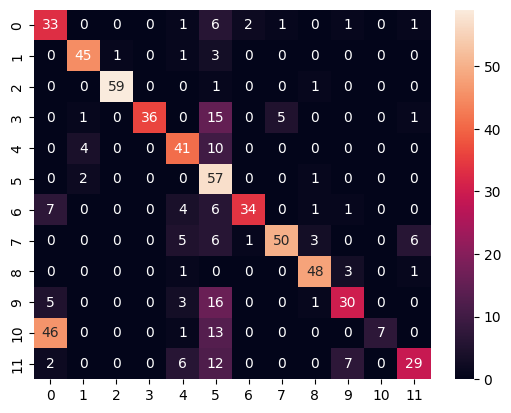

In [86]:
model = hd_model(X_train, X_test, y_train, y_test,256,10000,1)
with open('projection.txt', 'w') as f:
    for row in model.encoder.projection:
        f.write(" ".join(map(str, row)) + '\n')
# print(model.encoder.projection.shape)

model.train_()
with open('classEncoding.txt', 'w') as f:
    for row in model.class_hvs:
        f.write(" ".join(map(str, row)) + '\n')
model.test_()

In [42]:

print(model.encoder.projection[1000])

import json
import numpy as np


# for i in range(10000):
#   model.encoder.projection[i].tolist()
projection_list = model.encoder.projection.tolist()
#print(type(all_data[0]))

#print(all_data.shape)
for i in range(10000):
    count1 = 0
    countn1 = 0
    for j in range(256):
       
        if projection_list[i][j] == 1 : 
            count1 += 1
        else:
            countn1 += 1
    print("count1 "+ str(count1) + "countn1: " + str(countn1))
            

with open('projection.json', 'w') as json_file:
  json.dump(projection_list, json_file, indent=4)

[-1.  1. -1. -1.  1.  1. -1. -1. -1. -1. -1. -1. -1.  1. -1.  1.  1.  1.
  1.  1.  1.  1.  1. -1.  1.  1. -1.  1. -1.  1.  1.  1. -1. -1. -1. -1.
  1. -1.  1.  1. -1.  1. -1. -1.  1.  1.  1.  1. -1.  1.  1. -1.  1. -1.
 -1. -1. -1.  1. -1. -1. -1. -1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1.
  1. -1. -1. -1.  1. -1.  1. -1.  1.  1.  1. -1. -1.  1.  1. -1. -1.  1.
 -1. -1.  1.  1.  1. -1. -1.  1.  1. -1.  1. -1. -1. -1. -1. -1.  1. -1.
 -1.  1.  1. -1. -1. -1.  1.  1. -1. -1.  1.  1.  1.  1. -1.  1.  1.  1.
  1.  1. -1.  1.  1.  1.  1.  1. -1. -1. -1.  1. -1.  1. -1. -1.  1. -1.
  1.  1. -1.  1. -1. -1.  1. -1. -1.  1. -1. -1.  1. -1. -1.  1. -1. -1.
 -1.  1. -1. -1.  1. -1. -1.  1. -1.  1. -1.  1.  1. -1.  1. -1.  1. -1.
  1.  1. -1.  1. -1.  1. -1. -1.  1.  1. -1. -1. -1.  1. -1. -1.  1. -1.
 -1. -1. -1. -1. -1.  1. -1.  1. -1. -1. -1.  1. -1. -1. -1.  1. -1.  1.
 -1.  1.  1. -1. -1. -1.  1.  1. -1. -1. -1.  1.  1. -1. -1.  1. -1. -1.
 -1. -1. -1.  1. -1.  1.  1. -1. -1.  1.  1.  1. -1

0
377
1
274
2
241
0.75
0.7547002914855027
[[42  0  0  0  0  2  0  0  0  0  1  0]
 [ 0 45  2  0  1  2  0  0  0  0  0  0]
 [ 0  0 56  0  0  2  0  0  3  0  0  0]
 [ 0  0  0 44  0 14  0  0  0  0  0  0]
 [ 1  3  0  0 39  9  0  1  1  0  1  0]
 [ 0  1  0  0  0 58  0  0  1  0  0  0]
 [ 5  0  0  0  4  5 37  0  1  0  1  0]
 [ 2  0  0  0  0  5  0 56  3  4  0  1]
 [ 0  0  0  0  0  0  0  0 50  2  0  1]
 [ 4  0  0  0  0 16  0  0  3 32  0  0]
 [25  0  0  0  0 22  1  0  0  0 19  0]
 [ 3  3  0  0  5  9  0  0  0  1  0 35]]


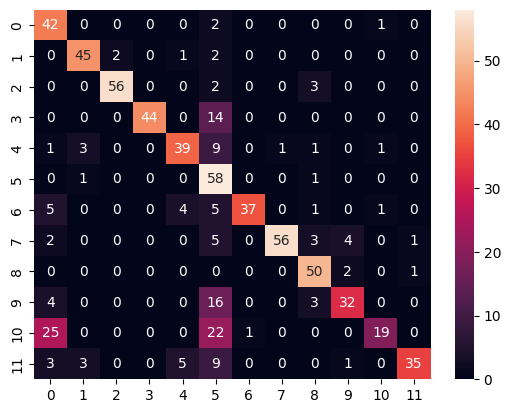

In [87]:
model.retrain()
model.test_()

In [88]:
class_hv = model.class_hvs.tolist()
with open('hypervector.json', 'w') as json_file:
  json.dump(class_hv, json_file, indent=4)